## Imports & setup

In [1]:
import os, sys, numpy as np
sys.path.append(os.path.abspath(".."))

from src.utils.config_loader import load_config
from src.numerics.laplacian_2d import make_laplacian_2d
from src.pdes.heat_solver_2d import run_heat_solver_2d
from src.core.time_integrators import rk4_step_op, euler_step_op, rk4_step, euler_step
from src.utils.diagnostics import DiagnosticManager, plot_mass_evolution
from src.visualization.plotting_2d import plot_initial_vs_final, plot_final_frame, animate_2d

## Load config, build grid & operator

**This cell accepts all of these config styles:**
- Scalars
    *grid: { L: 1.0, N: 256 }*

- Tuples
    *grid: { L: [1.0, 1.0], N: [256, 256] }*

- Optionally explicit spacings
    *grid: { N: [256, 256], dx: 1.0/256, dy: 1.0/256 }*

In [2]:
# Load config
cfg = load_config("../config.yaml")

# Physics / BC 
bc = cfg["bc"]["type"].lower()
alpha = float(cfg.get("physics", {}).get("params", {}).get("alpha", 1.0))

# Grid: accept scalars or tuples for N and L
g = cfg["grid"]
N_raw = g.get("N", 128)
L_raw = g.get("L", 1.0)

if isinstance(N_raw, (tuple, list)):
    Nx, Ny = int(N_raw[0]), int(N_raw[1])
else:
    Nx = Ny = int(N_raw)

if isinstance(L_raw, (tuple, list)):
    Lx, Ly = float(L_raw[0]), float(L_raw[1])
else:
    Lx = Ly = float(L_raw)

dx = float(g.get("dx", Lx / Nx))
dy = float(g.get("dy", Ly / Ny))

# Stability clamp for RK4 on 2D diffusion (use this dt later)
lam_max = 4.0 / dx**2 + 4.0 / dy**2
dt_user = float(cfg["time"]["dt"])
dt_max_rk4 = 2.785 / (alpha * lam_max)
dt = min(dt_user, 0.8 * dt_max_rk4)  # safety factor
print(f"[dt] user={dt_user:.3e}, rk4_max={dt_max_rk4:.3e}, using={dt:.3e}")

# Coordinates & mesh 
x = np.linspace(0.0, Lx, Nx, endpoint=False)
y = np.linspace(0.0, Ly, Ny, endpoint=False)
X, Y = np.meshgrid(x, y, indexing="xy")

# 2D Laplacian (tuple-style call; note dx= keyword!)
L2 = make_laplacian_2d((Nx, Ny), dx=(dx, dy), bc=bc)
L_op = alpha * L2

# Output dir 
outdir = cfg["io"]["outdir"]
os.makedirs(outdir, exist_ok=True)

[dt] user=2.500e-05, rk4_max=5.312e-06, using=4.250e-06


## Initial condition (radial Gaussian on a torus)

In [3]:
ic = cfg["initial_condition"]
amp = float(ic.get("amplitude", ic.get("amp", 1.0)))

center = ic.get("center", 0.5)
if isinstance(center, (tuple, list)):
    cx, cy = float(center[0]) * Lx, float(center[1]) * Ly
else:
    cx, cy = float(center) * Lx, float(center) * Ly

sigma_cfg = ic.get("sigma", 0.08)
if isinstance(sigma_cfg, (tuple, list)):
    sigx, sigy = float(sigma_cfg[0]) * Lx, float(sigma_cfg[1]) * Ly
else:
    sigx, sigy = float(sigma_cfg) * Lx, float(sigma_cfg) * Ly

if bc == "periodic":
    dxp = np.minimum(np.abs(X - cx), Lx - np.abs(X - cx))
    dyp = np.minimum(np.abs(Y - cy), Ly - np.abs(Y - cy))
else:  # dirichlet
    dxp, dyp = X - cx, Y - cy

eps = 1e-12
u0_field = amp * np.exp(-0.5 * ((dxp / max(sigx, eps))**2 + (dyp / max(sigy, eps))**2))
u0 = u0_field.reshape(Nx * Ny)

## Run solver, diagnostics, and plots

steps=2354  dt=4.250e-06  T=1.000e-02
mass drift: +0.000e+00   (rel +0.000e+00)


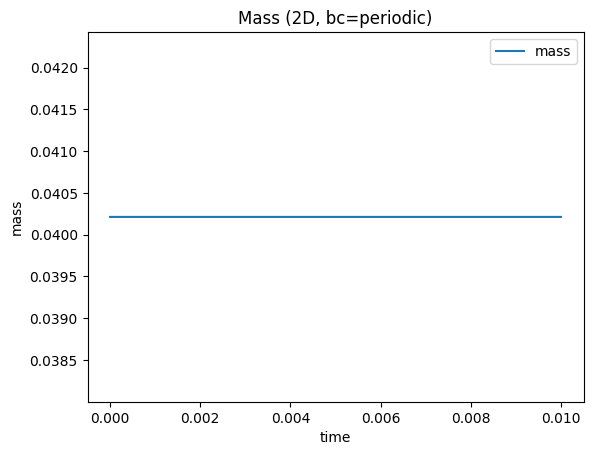

Saved diagnostics to figures
Saved Initial vs Final figure to figures/heat2d_initial_final.png


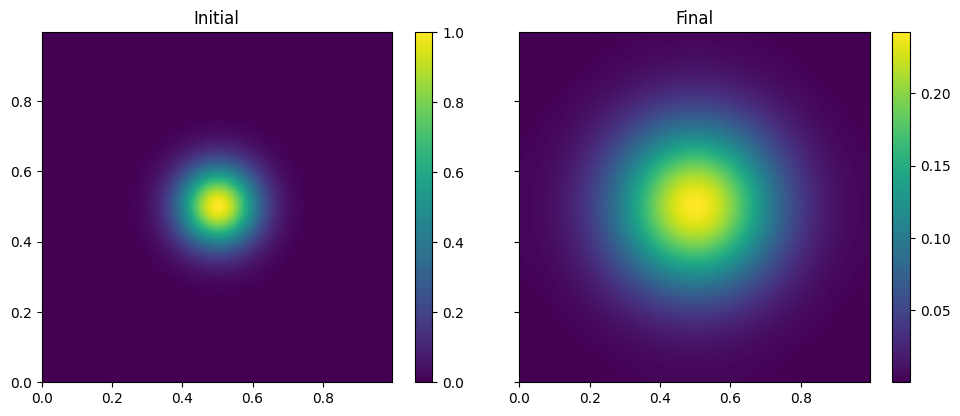

In [4]:
# --- Run solver with stable dt, diagnostics, and show BOTH plots inline ---

# Pick integrator
method = cfg["integrator"]["method"].lower()
step = {
    "rk4": rk4_step,
    "euler": euler_step,
    "rk4_op": rk4_step_op,
    "euler_op": euler_step_op,
}.get(method)
if step is None:
    raise ValueError(f"Unsupported integrator: {method}")

# Time horizon (dt is the clamped value computed earlier)
T = float(cfg["time"]["T"])

# Run (solver returns list of flattened states)
u_hist = run_heat_solver_2d(
    L_op=L_op,
    u0=u0,                # flattened u0_field
    Nx=Nx, Ny=Ny,
    T=T,
    dt=dt,                # <- clamped dt from setup cell
    dx=dx, dy=dy,
    step_func=step,
)

# Time vector
t_hist = np.arange(len(u_hist)) * dt

# Diagnostics (reshape to (Ny, Nx) for correct 2D mass via rectangle rule)
dm = DiagnosticManager(dx=dx, dy=dy, track=("mass", "l2_norm", "min", "max", "mean"))
for u, t in zip(u_hist, t_hist):
    dm.track_step(u.reshape(Ny, Nx), t)

# Quick sanity summary
m0 = dm.records[0]["mass"]; m1 = dm.records[-1]["mass"]
print(f"steps={len(u_hist)-1}  dt={dt:.3e}  T={T:.3e}")
print(f"mass drift: {m1 - m0:+.3e}   (rel {((m1 - m0)/(abs(m0)+1e-15)):+.3e})")

# 1) Mass vs time 
fig_mass, ax_mass, masses = plot_mass_evolution(
    [u.reshape(Ny, Nx) for u in u_hist],
    dx=dx, dy=dy,
    times=t_hist,
    title=f"Mass (2D, bc={bc})",
)

# 2) Initial vs Final — show inline AND save
fig_if = plot_initial_vs_final(
    u0_field,
    u_hist[-1].reshape(Ny, Nx),
    x, y,    # these are enough
)

# Save diagnostics
dm.save_csv(os.path.join(outdir, "heat2d_diagnostics.csv"))
dm.save_yaml(os.path.join(outdir, "heat2d_summary.yaml"))
print("Saved diagnostics to", outdir)
print("Saved Initial vs Final figure to", os.path.join(outdir, "heat2d_initial_final.png"))

AttributeError: 'AxesImage' object has no attribute 'set_aspect'

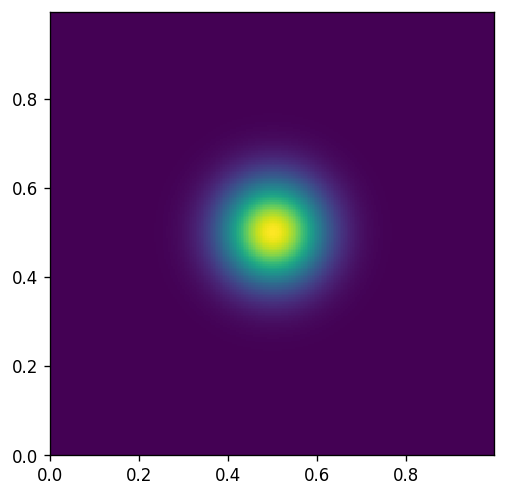

In [ ]:
# --- Animation + Initial/Final (consistent color scale & appearance) ---

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter

# Build frames (Ny, Nx) and lock global color limits
frames_2d = [u.reshape(Ny, Nx) for u in u_hist]
extent = (float(x.min()), float(x.max()), float(y.min()), float(y.max()))
vmin = float(np.min(frames_2d))
vmax = float(np.max(frames_2d))

# Sanity: last frame equals final solver state
assert np.allclose(frames_2d[-1], u_hist[-1].reshape(Ny, Nx)), "Last frame != final state"

# --- Animate with fixed vmin/vmax (so last MP4 frame matches PNG) ---
# Keep the current parameter name your function expects: u_history
anim = animate_2d(
    u_history=np.array(frames_2d),
    x=x, y=y,
    interval=50,
    filename=None,                 # we'll save it with an explicit writer
    cmap="viridis",
    stride=1,
    fps=20,
    dpi=120,
    vmin=vmin, vmax=vmax           # <-- fixed scale across all frames
)

# Save MP4 with explicit writer settings (reduces banding/shifts)
mp4_path = os.path.join(outdir, "heat2d.mp4")
writer = FFMpegWriter(
    fps=20,
    bitrate=8000,
    codec='libx264',
    extra_args=['-pix_fmt', 'yuv420p']
)
anim.save(mp4_path, writer=writer, dpi=120)
print("Saved animation to:", mp4_path)

# --- Initial vs Final: show inline AND save, with same vmin/vmax/extent/origin ---
fig_if, axes = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

im0 = axes[0].imshow(
    u0_field,
    extent=extent, origin="lower",
    cmap="viridis", vmin=vmin, vmax=vmax,
    interpolation='nearest'
)
axes[0].set_title("Initial")
axes[0].set_aspect('equal')

im1 = axes[1].imshow(
    frames_2d[-1],
    extent=extent, origin="lower",
    cmap="viridis", vmin=vmin, vmax=vmax,
    interpolation='nearest'
)
axes[1].set_title("Final")
axes[1].set_aspect('equal')

cbar = fig_if.colorbar(im1, ax=axes.ravel().tolist())
cbar.set_label("u")

png_path = os.path.join(outdir, "heat2d_initial_final.png")
fig_if.savefig(png_path, dpi=120, bbox_inches="tight")
print("Saved Initial vs Final figure to", png_path)

## Animation (MP4 if ffmpeg, else GIF)

In [5]:
# Build frames in (Ny, Nx) order
frames_2d = [u.reshape(Ny, Nx) for u in u_hist]

anim = animate_2d(
    u_history=np.array(frames_2d),  
    x=x, y=y,
    interval=50,
    filename=os.path.join(outdir, "heat2d.mp4"),
    cmap="viridis",
    stride=1,
    fps=20,
    dpi=120
)

print("Saved animation to:", os.path.join(outdir, "heat2d.mp4"))

Saved animation to: figures/heat2d.mp4
